Use TFIDF and Cosine similarity to define high probability scores and low probability scores to define positive and negative matches.  Then use semi-supervised learning to fill in the labels for the remaining matches.  

In [1]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt

porter = nltk.PorterStemmer()

% matplotlib inline
sns.set(style="darkgrid", color_codes=True)
stop = stopwords.words('english')
dir = 'C:\\Users\\Travis Park\\Google Drive\\UN\\Team MOZART RAP\\'

In [2]:
tfidfvectorizer =TfidfVectorizer(ngram_range = (1,2),sublinear_tf=False, 
                                 min_df = 0.01, max_features = 1100) 
def TFIDFtotable(inputlist1, inputlist2, newcollist):
    corpus = inputlist1 + inputlist2
    
    x = tfidfvectorizer.fit_transform(corpus)
    x = pd.DataFrame((x * x.T).A)
    
    x = x.ix[:len(inputlist1)-1,len(inputlist1):]
    x.columns = newcollist
    x['Text'] = trimtext
    x = pd.merge(x, Paragraph_DF, how = 'left', left_on = 'Text', right_on = 'StemText')
    x=x.drop(['Text_x','Text_y','TrimText','StemText'],1)
    x=pd.melt(x, id_vars=['Number'])
    x.rename(columns={'Number':'Paragraph','variable': 'Target','value':'T_Cosine'}, inplace = True)
    TFIDFTable = x    
   
    return TFIDFTable

In [3]:
def RemoveVerbs(string):
    if len(string) > 0:
        x = nltk.pos_tag(string.split(' '))
        x = [(word, tag) for (word, tag) in x
             if tag.startswith('N') 
             or tag.startswith('J')
             or tag.startswith('R')]
        x = ' '.join([i[0] for i in x])
        return x
    else:
        return 'x x'

Import SDG Goals and parse text

In [4]:
SDG_Targets = pd.read_excel(dir +'SDG_Goals.xlsx', names = ['ID', 'Goal','OrigionalText','GoalText'],sheetname = 'Sheet1')
SDG_Targets['TrimGoal'] = ''

targtext = []
x=0

while x < len(SDG_Targets):
    y = SDG_Targets['GoalText'][x].lower().replace('-',' ').split(' ')
    y = [z for z in y if z.isalpha() if z not in stop]
    targtext.append(' '.join(y))
    x=x+1
    
SDG_Targets['TrimGoal'] = targtext
SDG_Targets['ID'] = SDG_Targets['ID'].astype(int)
SDG_Targets.head(1)

,ID,Goal,OrigionalText,GoalText,TrimGoal
0,1,Poverty,Poverty End poverty in all its forms everywhere,poverty forms eveywhere,poverty forms eveywhere


In [5]:
test = list(SDG_Targets['TrimGoal'])

Import training text and clean

Training text is the Bhutan NDP and various other text chunks pertaining to SDGs

In [6]:
f = open(dir + 'Training_Doc.txt', 'r')
f = f.read().replace('. \n\n','.\n\n').replace('-',' ').replace('\x0c',' ').replace('...','').replace('Eleventh Five Year Plan',' ').split('.\n\n')
f = [w.replace('\n',' ') for w in f]

w=0
wlist=[]
while w<len(f):
    wlist.append(w)
    w=w+1

Paragraph_DF = pd.DataFrame(columns = ['Number','Text', 'TrimText'])
Paragraph_DF['Number'] = wlist
Paragraph_DF['Text'] = f

Remove stopwords and verbs

In [8]:
ttext = []
x = 0 
while x < len(Paragraph_DF):
    y = Paragraph_DF['Text'][x].lower().split(' ')
    y = [z for z in y if z.isalpha() if z not in stop]
    y = RemoveVerbs(' '.join(y))
    ttext.append(y)
    x=x+1
    
Paragraph_DF['TrimText'] = ttext

Stem the text

In [9]:
stemtext = []
x = 0
while x<len(Paragraph_DF):
    y = Paragraph_DF['TrimText'][x].split(' ')
    y = ' '.join([porter.stem(z) for z in y])
    stemtext.append(y)
    x=x+1
    
Paragraph_DF['StemText'] = stemtext

In [10]:
Paragraph_DF.head(1)

,Number,Text,TrimText,StemText
0,0,Main Document Volume I 1 ELEVENTH FIVE ...,main document volume eleventh year plan june m...,main document volum eleventh year plan june ma...


In [11]:
alldocs = ttext+targtext

Initialize TF-IDF vectorizer

Create Term-Document Matrix for all SDGs and Paragraphs in Training text

Calculate Cosine Similarity for all SDGs and Paragraphs in Training text

Trim table so it displays Cosine Similarity at the intersection of Paragraph (rows) and SDG (columns) in dataframe "z"

Dataframe "z2" is an unstacked version with Goal, Paragraph, and Cosine Similarity as columns filtered for non - zero values

In [12]:
stuff = "ngram_range = (1,2),sublinear_tf=False, min_df = 0.01, max_features = 1100"
tfidfvectorizer =TfidfVectorizer(ngram_range = (1,2),sublinear_tf=False, 
                                 min_df = 0.01, max_features = 1100) 

x = tfidfvectorizer.fit_transform(alldocs)
y = pd.DataFrame((x * x.T).A)

z = y.ix[:len(ttext)-1,len(ttext):]
z.columns = list(SDG_Targets['ID'])

z1=z.unstack().reset_index()
z1.columns = ['Goal','Paragraph','CosineSimilarity']
z2 = z1[(z1['Goal'] != z1['Paragraph']) & (z1['CosineSimilarity'] > 0)]

z2.sort_values(by = 'CosineSimilarity', ascending = False).head()

avg = z2['CosineSimilarity'].mean()
avg

0.07408536846829775

In [13]:
zx = z.reset_index()
zx.rename(columns={'index': 'paragraph'}, inplace=True)

For dataframe "x" (Term - Document Matrix) rename columns to feature names and only include Paragraph rows

In [14]:
x1 = pd.DataFrame(x.toarray(),columns = [tfidfvectorizer.get_feature_names()])
x1 = x1.ix[:len(ttext)-1,]
x1 = x1.reset_index()
c = zx.columns 

Append the Cosine Similarity to each Goal for each paragraph as columns

Format: Paragraph #, Term1 ... Term N, Goal1, Goal2 ... Goal17

In [15]:
x1.rename(columns={'level_0': 'paragraph'}, inplace=True)
xx = pd.merge(x1, zx, how = 'left', left_on = 'paragraph', right_on = 'paragraph')

In [58]:
xx.ix[58,1049:]

1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.031950
7     0.082011
8     0.011279
9     0.028059
10    0.000000
11    0.032916
12    0.049954
13    0.000000
14    0.189855
15    0.048593
16    0.055911
17    0.167185
Name: 58, dtype: float64

Calculate the Cosine Similarity for the top 5%

Any values for that Goal above the threshold will be defined as matches and used later in a generated training set

In [16]:
q = xx.ix[:,len(xx.columns)-17:].quantile(q = .95)
print(q)
q = list(q)

1     0.088550
2     0.095592
3     0.123701
4     0.108298
5     0.000000
6     0.100782
7     0.074953
8     0.104804
9     0.090345
10    0.103122
11    0.077436
12    0.092174
13    0.000000
14    0.095111
15    0.066243
16    0.102474
17    0.100191
dtype: float64


For each Goal, loop through each paragraph

If the Cosine Similarity is higher than the threshold defined in the previous step, label it as 1 (match)

If the Cosines Similarity is lower than the 0.0000001, label it as 0 (non match)

If it is between these two we are uncertain of its value so label it as False (uncertain), 
  we will then use the known labels to predict this one

In [17]:
i = 0
while i < len(q):
    j = 0
    while j < len(zx):
        #print(zx.ix[j,i+1])
        if zx.ix[j,i+1] >= q[i]:
            zx.ix[j,i+1] = 1
        elif zx.ix[j,i+1] < 0.0000001:
            zx.ix[j,i+1] = 0
        else:
            zx.ix[j,i+1] = -1
        j=j+1
    i=i+1 

Training data is the Term - Document Matrix for each paragraph

Labels are the labels defined in previous step

Still need to build looping function to work on all Goals, right now it only does the one defined

In [19]:
X = x1
y = zx.ix[:,6]

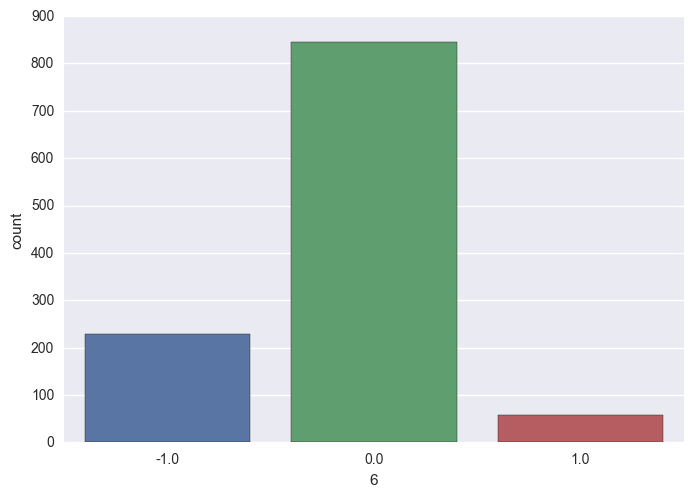

In [71]:
sns.countplot(y);

In [20]:
unlab_ls = x1
unlab_ls['lab'] = y

In [21]:
set(y)

{-1.0, 0.0, 1.0}

In [22]:
x1['Goal6'] = y
x1.head()

,paragraph,able,access,account,accountability,act,action,activities,activities proportion,acute,...,worst days,year,year mean,year net,years,yet,youth,zhemgang,lab,Goal6
0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.108385,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,2,0.0,0.211777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.273476,0.0,0.0,0.0
3,3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


Initialize Positive Naive Bayes Classifier (http://www.nltk.org/api/nltk.classify.html#module-nltk.classify)

This method only takes true values as training data and predicts a binary for inputs

In [23]:
from nltk.classify import PositiveNaiveBayesClassifier

In [24]:
pstv = x1[['paragraph','Goal6']][(x1['Goal6'] == 1)]

pstv_text = pd.merge(Paragraph_DF,pstv, how = 'inner',left_on = 'Number', right_on = 'paragraph')
pstv_list = list(pstv_text['TrimText'])

In [25]:
unlab = x1[['paragraph','Goal6']][(x1['Goal6'] == -1)]

unlab_text = pd.merge(Paragraph_DF,unlab, how = 'inner',left_on = 'Number', right_on = 'paragraph')
unlab_text['Label'] = ''
unlab_list = list(unlab_text['TrimText'])
unlab_list[100]

'main thrust area energy sector eleventh plan security sustainable'

In [26]:
def features(sentence):
    words = sentence.lower().split()
    return dict(('contains(%s)' % w, True) for w in words)

In [27]:
positive_featuresets = list(map(features, pstv_list))
unlabeled_featuresets = list(map(features, unlab_list))

In [96]:
clf = PositiveNaiveBayesClassifier.train(positive_featuresets, unlabeled_featuresets,positive_prob_prior=0.0005)

In [97]:
i = 0
while i < len(unlab_list):
    unlab_text['Label'][i] = clf.classify(features(unlab_list[i]))
    i=i+1

C:\Users\Travis Park\Anaconda3_1\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


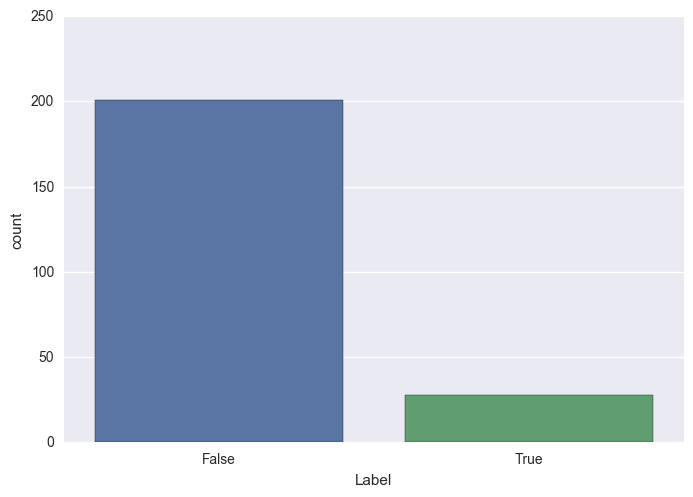

In [98]:
sns.countplot(x="Label", data=unlab_text);

In [99]:
Paragraph_DF['Label6'] = ''
i = 0
while i < len(Paragraph_DF):
    Paragraph_DF['Label6'][i] = clf.classify(features(Paragraph_DF['TrimText'][i]))
    i=i+1

C:\Users\Travis Park\Anaconda3_1\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


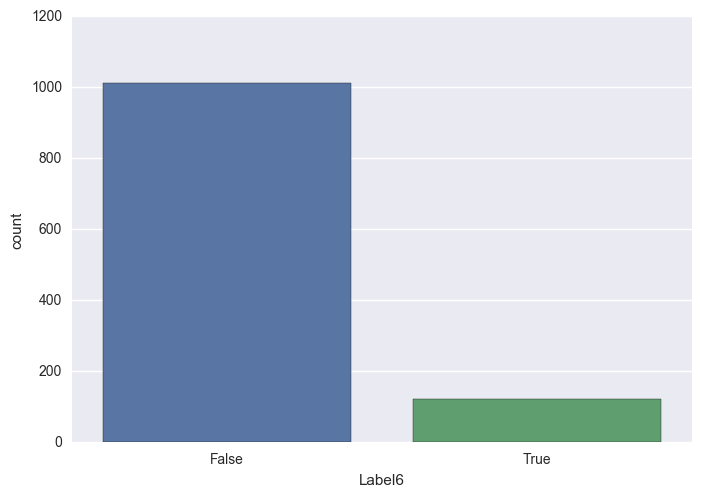

In [100]:
sns.countplot(x="Label6", data=Paragraph_DF);

Compare the Positive Naive Bayes Classifier with the results of a Label Spreading model (http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html)

Label Spreading is a semi-supervised model that takes a sparsely labelled dataset and extends labels based on natural groups or clusters that appear in the dataset

In [68]:
ls = LabelSpreading(kernel='rbf', gamma=20, n_neighbors=10,
                    alpha=0.2, max_iter=50, tol=0.001, n_jobs=-1).fit(X, y)
#ls100 = (label_propagation.LabelSpreading().fit(X, y), y)
#rbf_svc = (svm.SVC(kernel='rbf').fit(X, y), y)
ls.score(X,y)
a = ls.score(X,y)
output_labels = ls.transduction_
set(output_labels)

{0.0, 1.0}

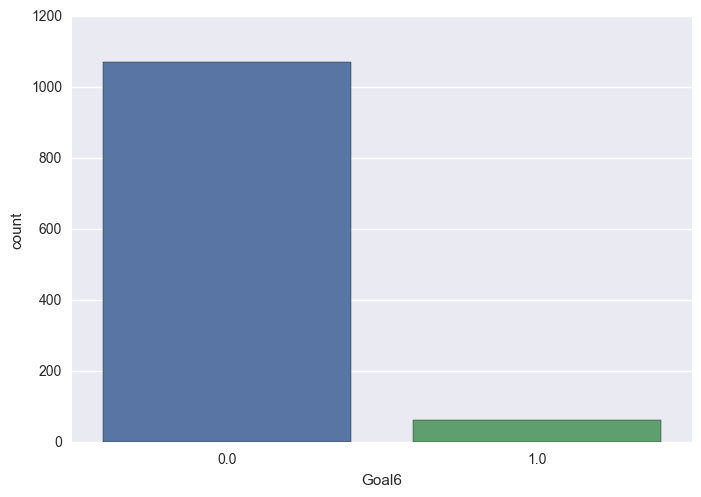

In [69]:
X['Goal6'] = output_labels
sns.countplot(x="Goal6", data=X)

It appears that Label Spreading is much more selective than the Positive Naive Bayes Classifier

To discover differences look at paragraphs labelled as True by the classifier, but False by Label Spreading

In [67]:
Paragraph_DF['Text'][326]

' The KPIs for NKRA 3 – Food Secure and Sustained – are as follows:  i) Cereal self sufficiency enhanced   Cereal sufficiency will be enhanced from 64  percent in 2011 to 75 percent by 2017 18. Disaggregated targets for production  of rice, maize, wheat etc are kept under RNR Sector’s key result areas.  ii) Milk sufficiency enhanced – The target is to increase from 90 percent in  2011 to 100 percent sufficiency'

In [102]:
temp = pd.merge(Paragraph_DF[['Number','Label6']], X[['paragraph','Goal6']], how = 'left', left_on = 'Number',right_on = 'paragraph')
temp[(temp['Goal6'] == 0) &(temp['Label6'] == True)]

,Number,Label6,paragraph,Goal6
9,9,True,9,0.0
22,22,True,22,0.0
96,96,True,96,0.0
180,180,True,180,0.0
191,191,True,191,0.0
202,202,True,202,0.0
326,326,True,326,0.0
331,331,True,331,0.0
334,334,True,334,0.0
339,339,True,339,0.0
